In [1]:
import os
import numpy as np
from helpers import *
from models import *   
from nan_imputation import impute_nan
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from load_data import load_lifespan, load_earlylifespan
from nan_imputation import *
from Preprocessing import *
from preprocessing_features import preprocess_dataset
from sklearn.preprocessing import StandardScaler
from evaluations import *

At first, import repository root and load data for regression (from the two controls and the company drug).

In [2]:
repo_root = find_repo_root()
data_path = os.path.join(repo_root, 'Data/Lifespan')
fdict = load_lifespan(data_path)

### Preprocessing ###

The preprocessing consists in :
- remove all Nan values;
- create initial class labels for both classification and regression;
- revise regression labels using death estimation function;
- perform data augmentation on worm coordinates;
- feature expansion, to get all summary features for lifespan time series;

In [3]:
cut_lifespan_dict = remove_nans(fdict) #remove nans
labels = create_classes(cut_lifespan_dict) #create array with 
revised_death_times = estimate_death_times(cut_lifespan_dict) #correct estimated death times

#now we can create the first official version of the regression and classification label vectors
y_reg = np.array(revised_death_times)
y_class = np.array(labels[:,0].astype(int))

#data augmentation, getting final label vectors and samples list, which is 2 times bigger than the original one
samples, y_reg_final, y_class_final = augment_worms(cut_lifespan_dict, y_reg, y_class)

#feature expansion from samples list
features = list(preprocess_dataset(samples)) #get the final features
X = pd.DataFrame(features[0:len(features)+1]) #create the features dataframe

Then, before performing any prediction task, we also have to:
- split between training and test sets for both tasks;
- normalize the dataframe with a standard scaler.

In [4]:
#do this for regression first
X_train, X_test, y_train, y_test = train_test_split(X, y_reg_final, test_size=0.2, random_state=42)
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.transform(X_train)
X_test_std = stdsc.transform(X_test)

#and now for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class_final, test_size=0.2, random_state=42)
stdsc.fit(X_train_c)
X_train_std_c = stdsc.transform(X_train_c)
X_test_std_c = stdsc.transform(X_test_c)

## Linear Regression ##

We can finally run linear regression to predict worm lifespan! Note that the task is to predict how many frames the worm will live given early lifespan. As the first worm died after 42.000 frames, the early lifespan threshold was manually adjusted to 35k frames.

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_std, y_train)
y_pred_lr = model.predict(X_test_std)

The model is then evaluated in this way:
- quantitatively with r-squared coefficient, MAE and RMSE;
- qualitatively, by plotting survival curves obtained with scikit-survival's Kaplain-Meier estimator ran on predicted and true lifespans.

In [6]:
quant_evaluation(y_test, y_pred_lr) #quantitative evaluation

Model Performances: 
Root Mean Squared Error (RMSE): 3011.8788528441232
Mean Absolute Error (MAE): 2216.395344155623
R-squared: 0.855111915344054


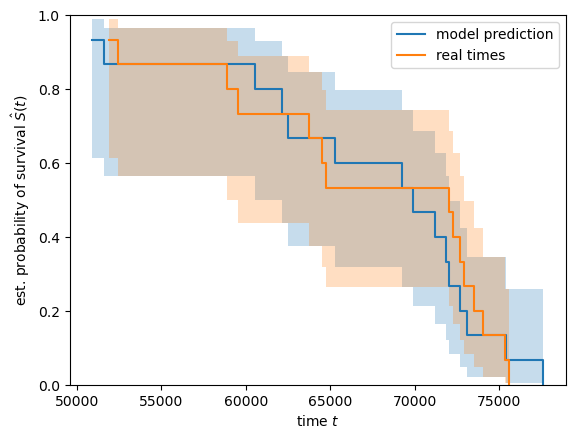

In [7]:
double_curve(y_test, y_pred_lr) #qualitative evaluation